In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats

In [2]:
# processing and importing table
cpl_parameters = pd.read_table('cpl_pars.txt', sep='|')
cpl_parameters = cpl_parameters.drop(columns = [ ' Trig_ID ', ' norm ', ' norm_low ',
       ' norm_hi ', ' chi2 ', ' dof ', ' reduced_chi2 ', ' null_prob ',
       ' enorm ', ' Exposure_time ', ' Spectrum_start ', ' Spectrum_stop ',' comment'])
cpl_parameters = cpl_parameters.rename(columns=lambda x: x.strip())
cpl_parameters = cpl_parameters.drop(columns = ['alpha', 'alpha_low', 'alpha_hi'])
cpl_parameters.columns = cpl_parameters.columns.str.replace(' ', '') #strip dataframe of white space

In [3]:
cpl_parameters = cpl_parameters.replace(' N/A ', np.nan)
# formatting column values as float values
cpl_parameters = cpl_parameters.astype({'Epeak':'float64', 'Epeak_low':'float64', 'Epeak_hi':'float64'})

In [4]:
swift_data = pd.read_csv('swift_data.csv', sep='\t')

In [5]:
cpl_parameters.rename(columns={'GRBname':'GRB Name'}, inplace=True)
cpl_parameters['GRB Name'] = cpl_parameters['GRB Name'].str.strip()
cpl_swift = pd.merge(swift_data, cpl_parameters)

In [6]:
# Removing GRBs with very high Epeaks i.e near the top of the sensor capablities
cpl_swift = cpl_swift.sort_values(['Epeak'], ascending=False)
cpl_swift = cpl_swift.loc[(cpl_swift['Epeak'] < 9500)]

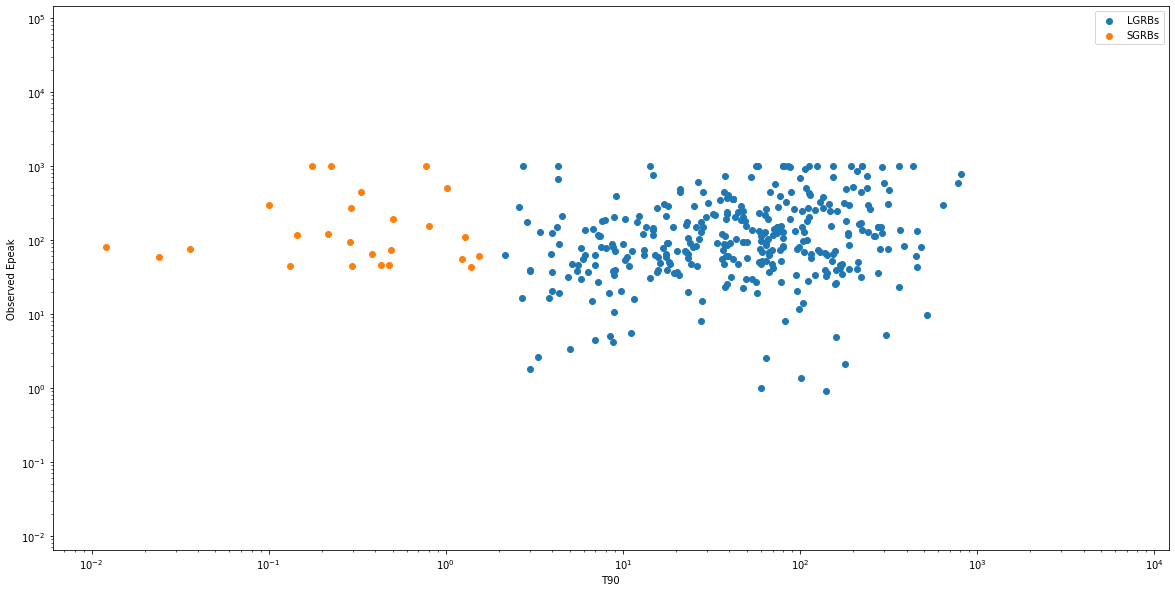

In [7]:
plt.figure(figsize=(20,10)) #sets figure size
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
LGRBs = cpl_swift.loc[(cpl_swift['T90']> 2)]
SGRBs = cpl_swift.loc[(cpl_swift['T90'] < 2)]

plt.scatter(LGRBs['T90'], LGRBs['Epeak'])
plt.scatter(SGRBs['T90'], SGRBs['Epeak'])
plt.legend(['LGRBs','SGRBs'])
plt.xlabel('T90')
plt.ylabel('Observed Epeak')
plt.show()

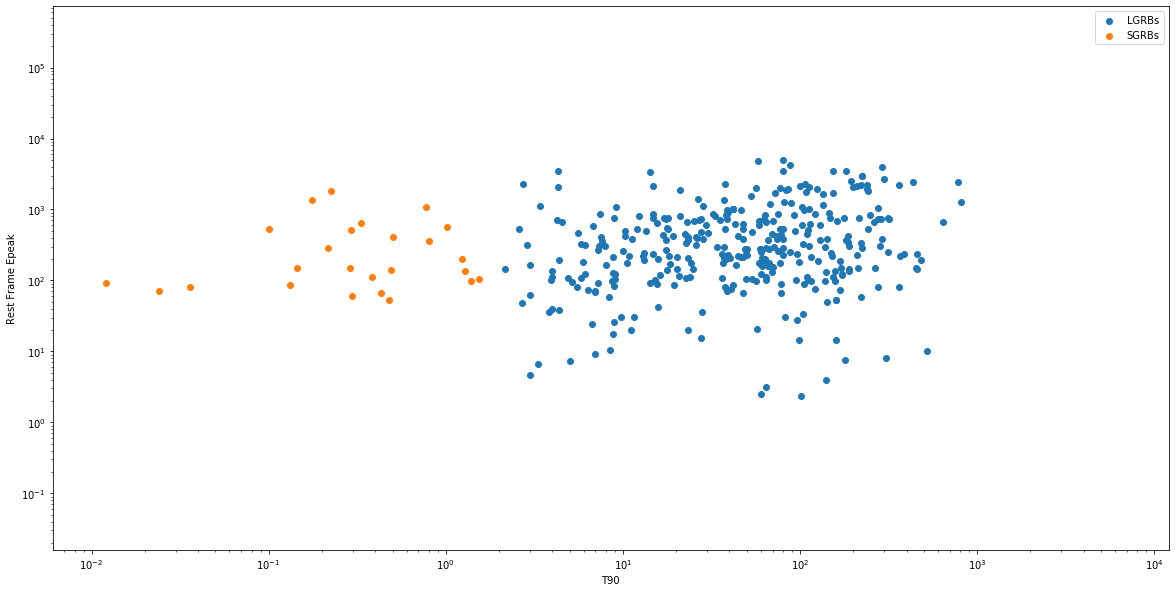

In [8]:
# making restframe Epeak column, we note the rest frame Epeak = (1+z)Epeak(obs)

cpl_swift['Rest Frame Epeak'] = (1 + cpl_swift['z'])*cpl_swift['Epeak']

# plot rest frame Epeak against T90

plt.figure(figsize=(20,10)) #sets figure size
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
LGRBs = cpl_swift.loc[(cpl_swift['T90']> 2)]
SGRBs = cpl_swift.loc[(cpl_swift['T90']< 2)]

plt.scatter(LGRBs['T90'], LGRBs['Rest Frame Epeak'])
plt.scatter(SGRBs['T90'], SGRBs['Rest Frame Epeak'])
plt.legend(['LGRBs','SGRBs'])
plt.xlabel('T90')
plt.ylabel('Rest Frame Epeak')
plt.show()

In [9]:
def epeak_for_z(int1, int2, GRB_list):
    """
    Takes in 2 integer values and a data frame of GRBs (long or short), which represent range of z values of LGRBs, 
    and outputs an average Epeak value
    """
    GRB_list_zrange = GRB_list.loc[(GRB_list['z']> int1) & (GRB_list['z'] < int2)]
    return GRB_list_zrange['Rest Frame Epeak'].mean()

In [10]:
def epeak_z_list(step):
    """
    In this function we have an input of "step" value, i.e. input of 0.1 will mean the step size of the function 
    will be 0.1 from 0 until maz z value. Then from that step value, the output is the average value of the range of 
    Epeak values for that step, i.e., for step 0.1, we will get corresponding range of average Epeak values for LGRBs
    from 0-01, 0.1-0.2,... etc. until max z value. This is then plotted of the average Epeak values against z.
    """
    lgrbs_z = []
    lgrbs_epeak = []
    int1 = 0
    for i in np.arange(step, max(LGRBs.z)+1, step):
        lgrbs_z.append(i)
        epeak_value = epeak_for_z(int1, i, LGRBs)
        lgrbs_epeak.append(epeak_value)
        int1 = i
    
    sgrbs_z = []
    sgrbs_epeak = []
    int1 = 0
    for i in np.arange(step, max(SGRBs.z)+1, step):
        sgrbs_z.append(i)
        sgrbs_value = epeak_for_z(int1, i, SGRBs)
        sgrbs_epeak.append(sgrbs_value)
        int1 = i
    
    n = int(1.5/step)
    i = sgrbs_epeak[:n]
    j = lgrbs_epeak[:n]
    print(stats.ks_2samp(i,j))
    #plots the scatter
    plt.figure(figsize=(20,10)) #sets figure size
    plt.bar(lgrbs_z, lgrbs_epeak, width=step, alpha=0.5, color='blue')
    plt.bar(sgrbs_z, sgrbs_epeak, width=step, alpha=0.5 ,color='orange')
    #plt.vlines(lgrbs_z, 0, max(lgrbs_epeak), linestyles = 'dotted')
    plt.ylabel('Rest frame Epeak', fontsize=20)
    plt.xlabel('z', fontsize=20)
    plt.legend(['LGRBs', 'SGRBs'])
    plt.show()

Ks_2sampResult(statistic=0.16666666666666666, pvalue=0.9999999999999998)


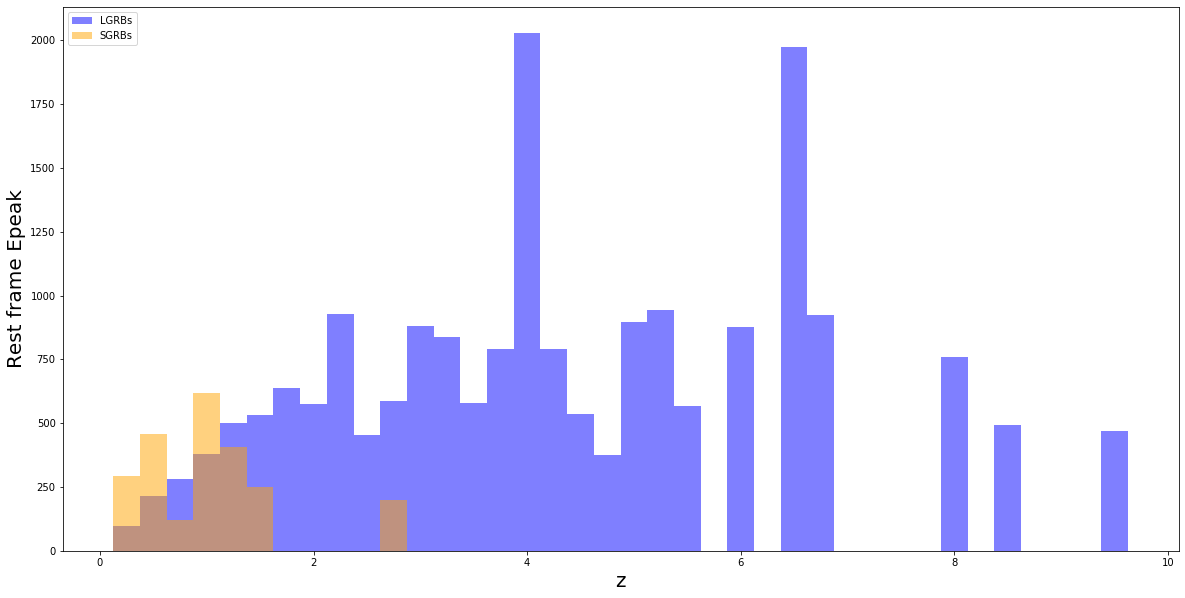

In [11]:
epeak_z_list(0.25)

Ks_2sampResult(statistic=0.3333333333333333, pvalue=1.0)


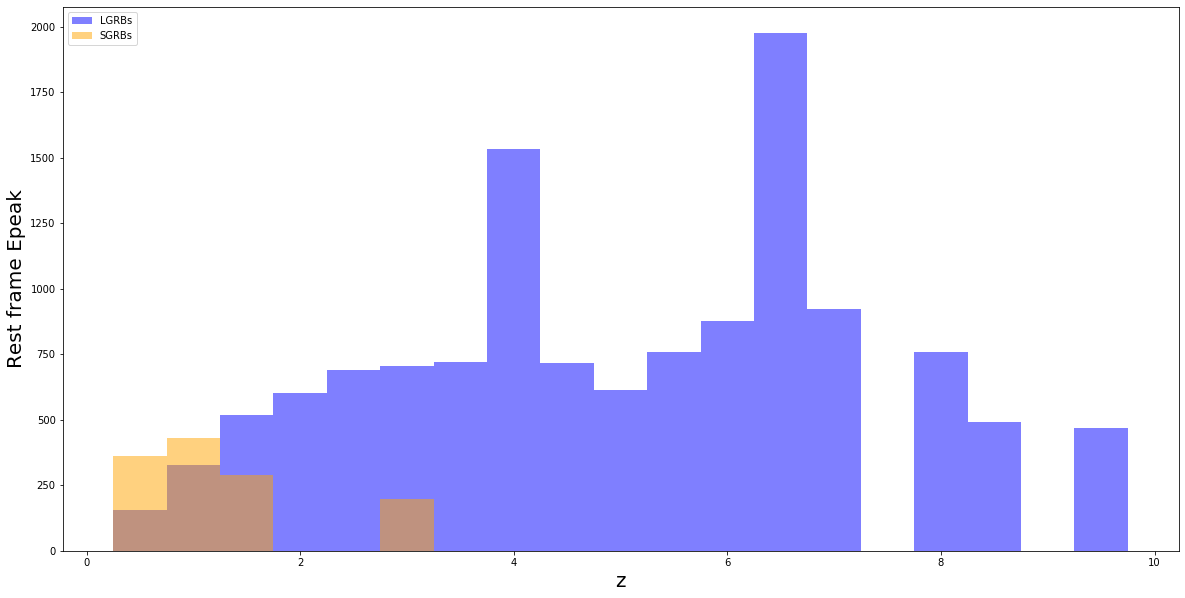

In [12]:
epeak_z_list(0.5)

In [13]:
cpl_swift.to_csv('cpl_swift', index= False)